In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def analyze_csv(J, K, p, csv_path=None):
    """
    Read simulation results from the CSV file for matrices of size J x K and probability p,
    aggregate the average runtime and average proportion identifiable across seeds,
    and plot the branches distribution.

    Parameters:
      J (int): Number of rows.
      K (int): Number of columns.
      p (float): Bernoulli probability used in simulation.
      csv_path (str): Optional path to the CSV file. If not provided, uses
                      "data/runtime_expr_results_J{J}_K{K}.csv".

    Returns:
      dict: A dictionary containing overall average runtime, average prop_identifiable,
            and the average branch distribution (as a dict).
    """
    if csv_path is None:
        csv_path = f"idQ_expr_J{J}_K{K}_p{p}.csv"
    # Read the CSV file into a DataFrame.
    df = pd.read_csv(csv_path)
    
    # If the CSV contains rows with different p values, filter for our specified p.
    df = df[df['p'] == p]
    
    # Compute overall average runtime and prop_identifiable across seeds.
    avg_runtime = df['avg_runtime'].mean()
    avg_prop_identifiable = df['prop_identifiable'].mean()
    
    # The CSV includes separate branch count columns: 'branch_-1', 'branch_0', ..., 'branch_6'.
    branch_cols = [f'branch_{i}' for i in [-1, 0, 1, 2, 3, 4, 5, 6]]
    branch_distribution = df[branch_cols].mean()  # Average count for each branch across seeds

    # Plot the branch distribution as a bar chart.
    plt.figure(figsize=(8, 4))
    branch_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Branch')
    plt.ylabel('Average Count per Seed')
    plt.title(f'Branch Distribution for J={J}, K={K}, p={p}')
    plt.tight_layout()
    plt.show()

    # Return results as a dictionary.
    return {
        'avg_runtime': avg_runtime,
        'avg_prop_identifiable': avg_prop_identifiable,
        'branch_distribution': branch_distribution.to_dict()
    }


In [2]:
J = 50
K = 15
p = 0.2

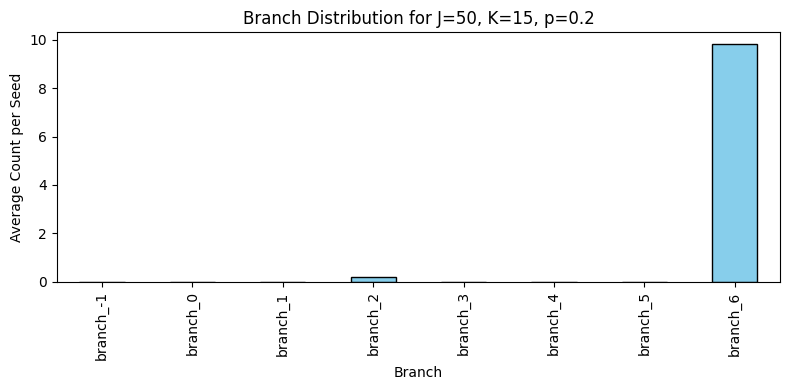

{'avg_runtime': 225.5603434169686,
 'avg_prop_identifiable': 0.982,
 'branch_distribution': {'branch_-1': 0.0,
  'branch_0': 0.0,
  'branch_1': 0.0,
  'branch_2': 0.18,
  'branch_3': 0.0,
  'branch_4': 0.0,
  'branch_5': 0.0,
  'branch_6': 9.82}}

In [3]:
analyze_csv(J, K, p)

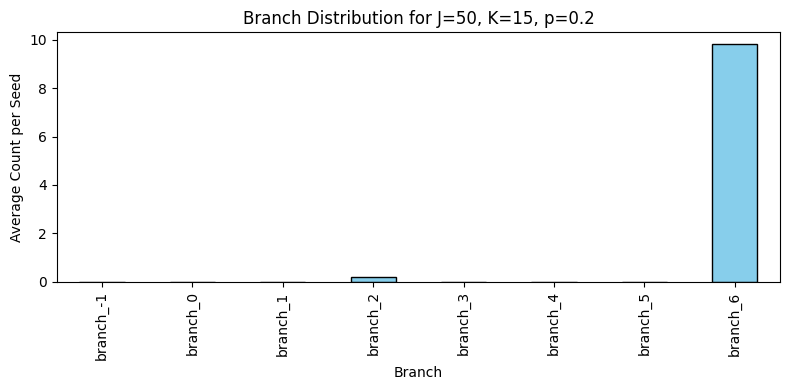

{'avg_runtime': 162.53155721830763,
 'avg_prop_identifiable': 0.982,
 'branch_distribution': {'branch_-1': 0.0,
  'branch_0': 0.0,
  'branch_1': 0.0,
  'branch_2': 0.18,
  'branch_3': 0.0,
  'branch_4': 0.0,
  'branch_5': 0.0,
  'branch_6': 9.82}}

In [7]:
analyze_csv(J, K, p)

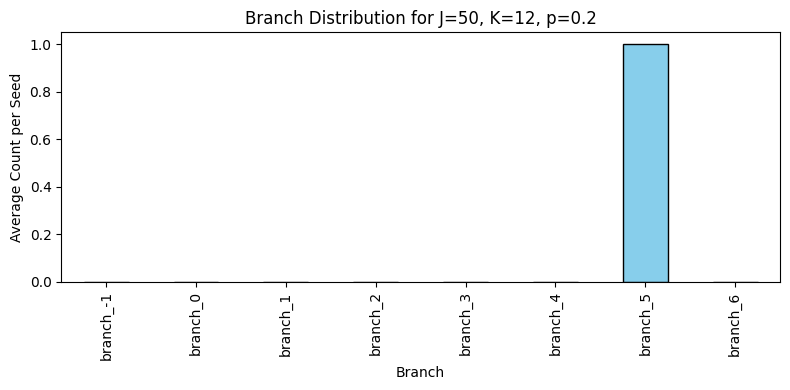

{'avg_runtime': 606.5833226525225,
 'avg_prop_identifiable': 0.0,
 'branch_distribution': {'branch_-1': 0.0,
  'branch_0': 0.0,
  'branch_1': 0.0,
  'branch_2': 0.0,
  'branch_3': 0.0,
  'branch_4': 0.0,
  'branch_5': 1.0,
  'branch_6': 0.0}}

In [17]:
analyze_csv(J = 50, K = 12, p = 0.2)

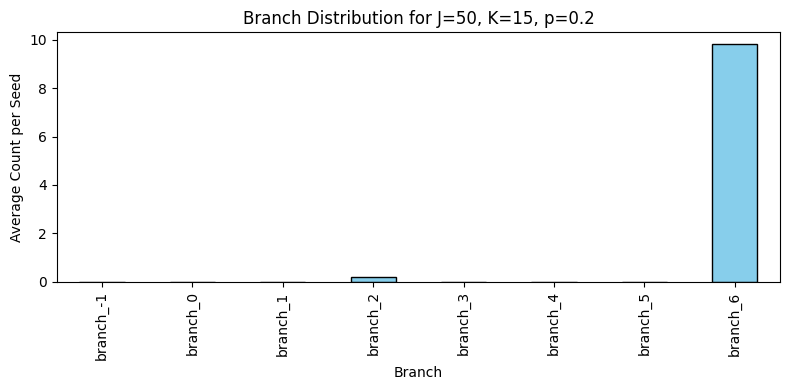

{'avg_runtime': 92.45360555250993,
 'avg_prop_identifiable': 0.9820000000000002,
 'branch_distribution': {'branch_-1': 0.0,
  'branch_0': 0.0,
  'branch_1': 0.0,
  'branch_2': 0.18,
  'branch_3': 0.0,
  'branch_4': 0.0,
  'branch_5': 0.0,
  'branch_6': 9.82}}

In [9]:
analyze_csv(J, K, p)

In [10]:
# Read the CSV file into a DataFrame.
df_v0 = pd.read_csv(f"idQ_expr_J{J}_K{K}_p{p}.csv")
df_v1 = pd.read_csv(f"idQ_expr_J{J}_K{K}_p{p}_v0.csv")

In [11]:
import pandas as pd

# 1) Merge the two DataFrames on seed, adding suffixes so you can see v0 vs v1
df_v01 = pd.merge(df_v0, df_v1, on='seed', suffixes=('_v0','_v1'))

# 2) For every other column, compute a “diff” column = v1 − v0
for col in df_v0.columns:
    if col == 'seed': 
        continue
    df_v01[f'{col}_diff'] = df_v01[f'{col}_v1'] - df_v01[f'{col}_v0']

# Now df contains columns like: seed, X_v0, X_v1, X_diff, Y_v0, Y_v1, Y_diff, …
print(df_v01.head())


   J_v0  K_v0  N_v0  p_v0  seed  avg_runtime_v0  prop_identifiable_v0  \
0    50    15    10   0.2    80      156.770171                   0.9   
1    50    15    10   0.2     5      176.553483                   0.9   
2    50    15    10   0.2    37      173.593346                   0.9   
3    50    15    10   0.2    53      172.716578                   0.9   
4    50    15    10   0.2    28      176.051314                   0.9   

   branch_-1_v0  branch_0_v0  branch_1_v0  ...  avg_runtime_diff  \
0             0            0            0  ...        -54.626594   
1             0            0            0  ...        -32.884144   
2             0            0            0  ...        -69.438010   
3             0            0            0  ...        -46.291015   
4             0            0            0  ...         22.923813   

   prop_identifiable_diff  branch_-1_diff  branch_0_diff  branch_1_diff  \
0                     0.0               0              0              0   
1 

In [12]:
df_v01

,J_v0,K_v0,N_v0,p_v0,seed,avg_runtime_v0,prop_identifiable_v0,branch_-1_v0,branch_0_v0,branch_1_v0,...,avg_runtime_diff,prop_identifiable_diff,branch_-1_diff,branch_0_diff,branch_1_diff,branch_2_diff,branch_3_diff,branch_4_diff,branch_5_diff,branch_6_diff
0,50,15,10,0.2,80,156.770171,0.9,0,0,0,...,-54.626594,0.0,0,0,0,0,0,0,0,0
1,50,15,10,0.2,5,176.553483,0.9,0,0,0,...,-32.884144,0.0,0,0,0,0,0,0,0,0
2,50,15,10,0.2,37,173.593346,0.9,0,0,0,...,-69.438010,0.0,0,0,0,0,0,0,0,0
3,50,15,10,0.2,53,172.716578,0.9,0,0,0,...,-46.291015,0.0,0,0,0,0,0,0,0,0
4,50,15,10,0.2,28,176.051314,0.9,0,0,0,...,22.923813,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,50,15,10,0.2,38,331.557932,1.0,0,0,0,...,-197.340089,0.0,0,0,0,0,0,0,0,0
96,50,15,10,0.2,45,354.573443,1.0,0,0,0,...,48.536727,0.0,0,0,0,0,0,0,0,0
97,50,15,10,0.2,24,417.272413,1.0,0,0,0,...,-40.199692,0.0,0,0,0,0,0,0,0,0
98,50,15,10,0.2,94,429.990765,1.0,0,0,0,...,-158.213054,0.0,0,0,0,0,0,0,0,0


In [13]:
any(df_v01["avg_runtime_diff"] < 0)

True

In [14]:
any(df_v01["prop_identifiable_diff"] > 0)

False

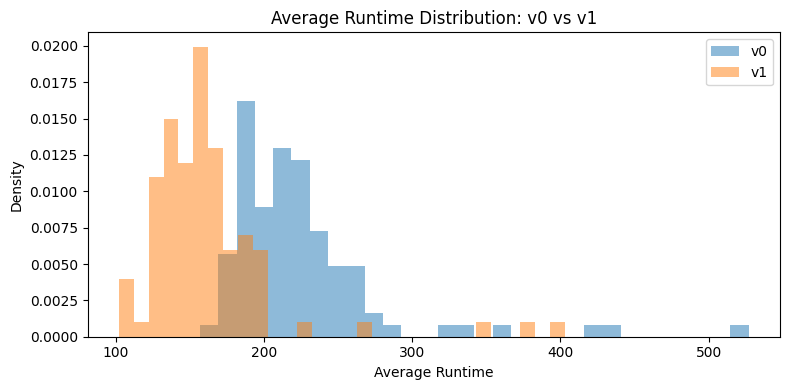

In [16]:
import matplotlib.pyplot as plt

# Assuming df_v0 and df_v1 are already loaded in the environment
plt.figure(figsize=(8, 4))
plt.hist(df_v0['avg_runtime'], bins=30, density=True, alpha=0.5, label='v0')
plt.hist(df_v1['avg_runtime'], bins=30, density=True, alpha=0.5, label='v1')
plt.xlabel('Average Runtime')
plt.ylabel('Density')
plt.title('Average Runtime Distribution: v0 vs v1')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_results(solver, J, K, p, data_dir="../data"):
    """
    Read the CSV for given parameters and compute:
    1. Average runtime across all simulations.
    2. Average runtime for simulations where branch == 6.
    3. Proportion of simulations that are identifiable.
    4. Plot the distribution of the 'branch' variable.
    
    Handles mixed-type 'identifiable' values and prints summary to console.
    """
    filename = f"{data_dir}/solver{solver}_J{J}_K{K}_p{p}.csv"
    df = pd.read_csv(filename)
    
    # Convert mixed 'identifiable' to int 0/1
    df['identifiable'] = df['identifiable'].apply(
        lambda x: 1 if str(x).strip().lower() in ('1', 'true', 't', 'yes') else 0
    )

    # 1. Average runtime
    avg_runtime = df['runtime'].mean()
    
    # 2. Average runtime for branch == 6
    branch6 = df[df['branch'] == 6]
    avg_runtime_branch6 = branch6['runtime'].mean() if not branch6.empty else float('nan')
    
    # 3. Proportion identifiable
    prop_identifiable = df['identifiable'].mean()
    
    # Print summary
    summary = pd.DataFrame({
        'Metric': [
            'Average runtime (all sims)',
            'Average runtime (branch=6)',
            'Proportion identifiable'
        ],
        'Value': [
            avg_runtime,
            avg_runtime_branch6,
            prop_identifiable
        ]
    })
    print("\nSummary Statistics:")
    print(summary.to_string(index=False))
    
    # 4. Plot distribution of branch
    counts = df['branch'].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    counts.plot(kind='bar')
    plt.xlabel('Branch value')
    plt.ylabel('Count')
    plt.title(f'Distribution of branch for solver={solver}, J={J}, K={K}, p={p}')
    plt.tight_layout()
    plt.show()
    
    return avg_runtime, avg_runtime_branch6, prop_identifiable



Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.520426
Average runtime (branch=6) 1.004108
   Proportion identifiable 0.732053


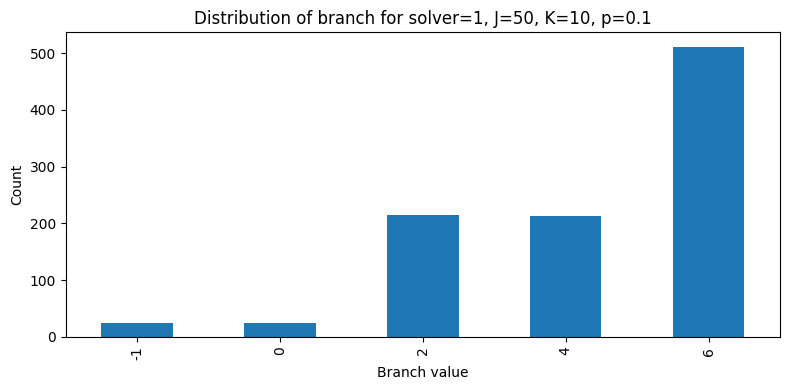

(0.5204263407676043, 1.0041078350604913, 0.7320525783619818)

In [13]:
analyze_results(solver = 1, J = 50, K = 10, p = 0.1)


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 1.771229
Average runtime (branch=6) 1.853528
   Proportion identifiable 0.994944


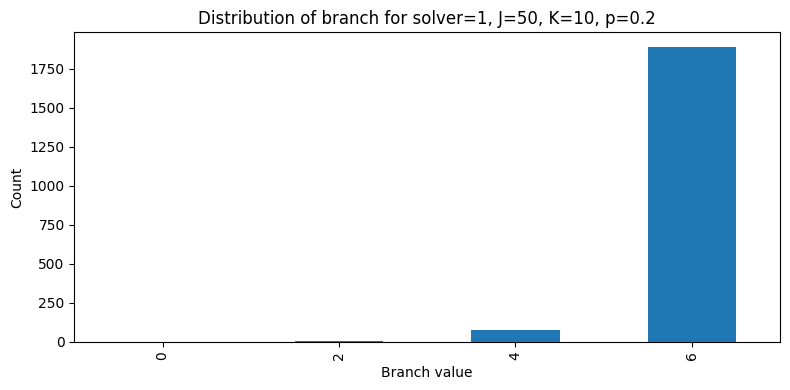

(1.7712290248678455, 1.8535284942776709, 0.9949443882709808)

In [14]:
analyze_results(solver = 1, J = 50, K = 10, p = 0.2)


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 2.957839
Average runtime (branch=6) 2.960810
   Proportion identifiable 0.998995


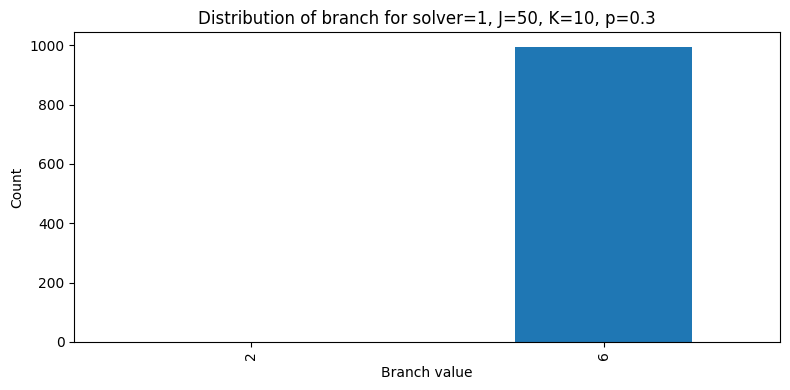

(2.9578392286313435, 2.960810244401146, 0.9989949748743718)

In [15]:
analyze_results(solver = 1, J = 50, K = 10, p = 0.3)


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 2.891905
Average runtime (branch=6) 2.891905
   Proportion identifiable 1.000000


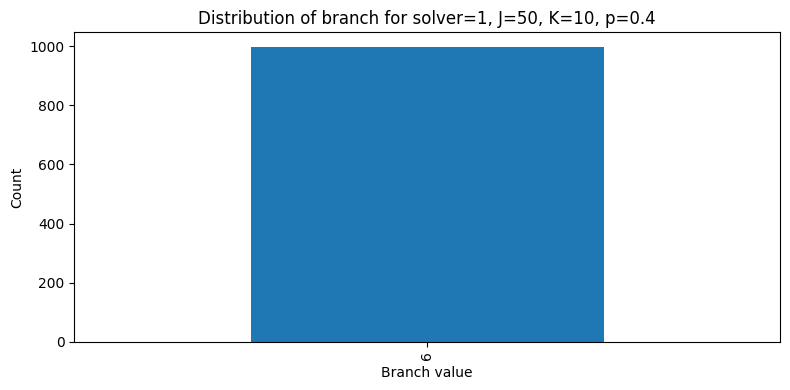

(2.8919051603004036, 2.8919051603004036, 1.0)

In [16]:
analyze_results(solver = 1, J = 50, K = 10, p = 0.4)


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 2.190613
Average runtime (branch=6) 2.190613
   Proportion identifiable 1.000000


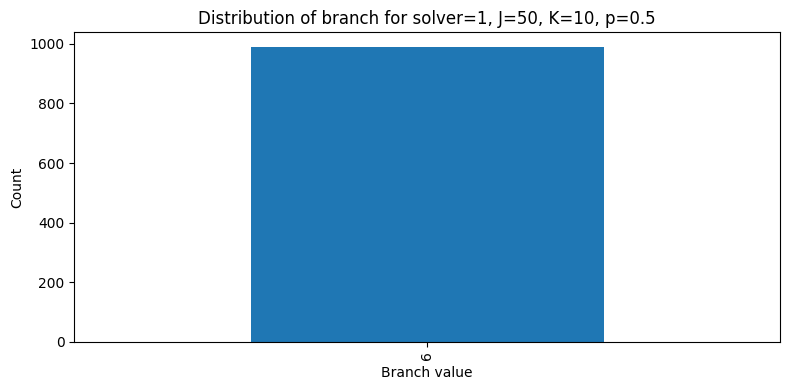

(2.190613354982844, 2.190613354982844, 1.0)

In [18]:
analyze_results(solver = 1, J = 50, K = 10, p = 0.5)


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 2.538714
Average runtime (branch=6) 2.539262
   Proportion identifiable 0.998998


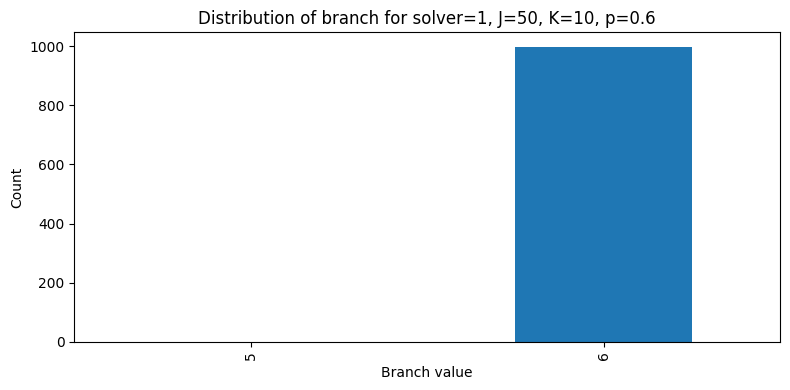

(2.5387143764207662, 2.5392615556137295, 0.998997995991984)

In [19]:
analyze_results(solver = 1, J = 50, K = 10, p = 0.6)


Summary Statistics:
                    Metric     Value
Average runtime (all sims)  9.599693
Average runtime (branch=6) 10.024385
   Proportion identifiable  0.924925


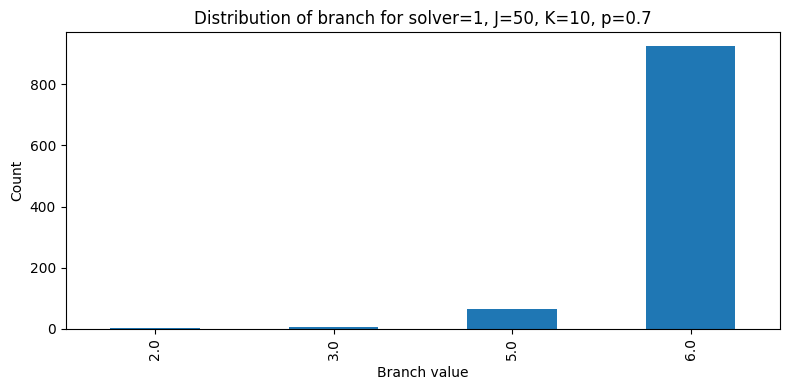

(9.599693339418005, 10.024385042561649, 0.924924924924925)

In [20]:
analyze_results(solver = 1, J = 50, K = 10, p = 0.7)


Summary Statistics:
                    Metric     Value
Average runtime (all sims)  3.821633
Average runtime (branch=6) 65.530971
   Proportion identifiable  0.038423


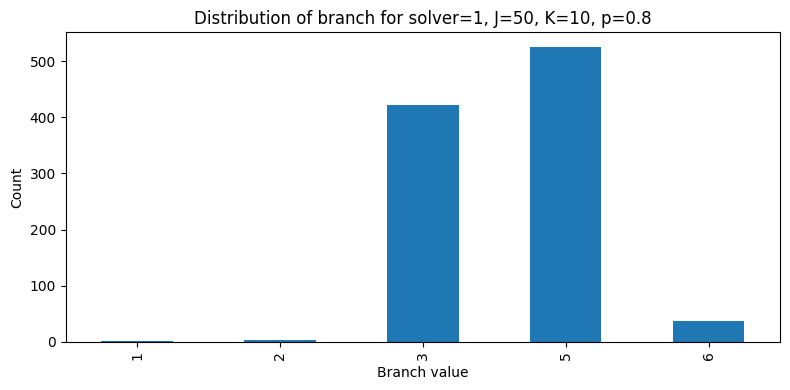

(3.821633353715911, 65.53097099914388, 0.03842264914054601)

In [21]:
analyze_results(solver = 1, J = 50, K = 10, p = 0.8)


Summary Statistics:
                    Metric    Value
Average runtime (all sims) 0.001897
Average runtime (branch=6)      NaN
   Proportion identifiable 0.000000


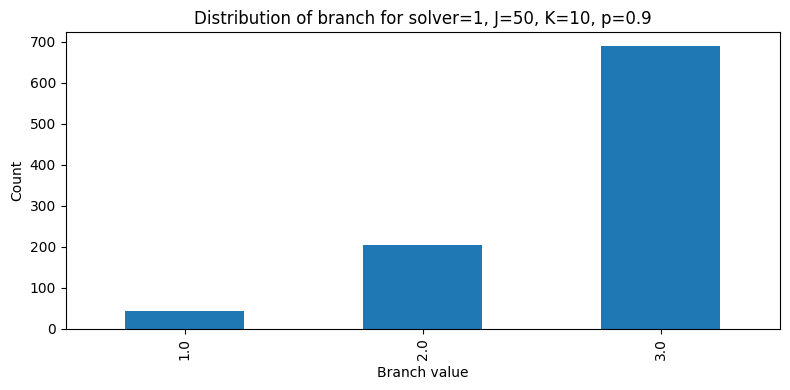

(0.0018972623513080667, nan, 0.0)

In [22]:
analyze_results(solver = 1, J = 50, K = 10, p = 0.9)


Summary Statistics:
                    Metric      Value
Average runtime (all sims)  65.620867
Average runtime (branch=6) 118.967525
   Proportion identifiable   0.551346


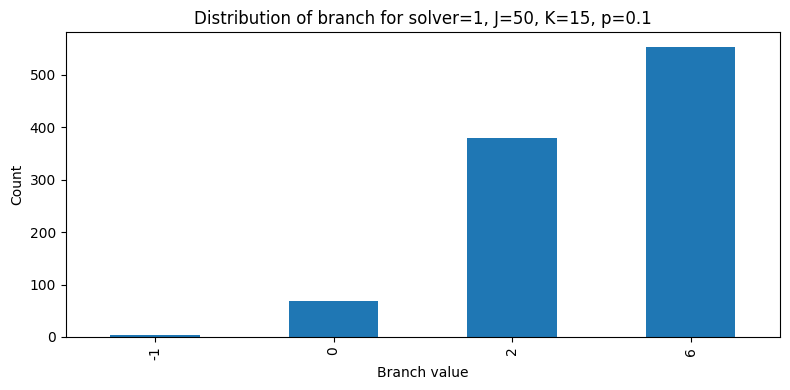

(65.6208674999147, 118.96752529146944, 0.551345962113659)

In [23]:
analyze_results(solver = 1, J = 50, K = 15, p = 0.1)


Summary Statistics:
                    Metric      Value
Average runtime (all sims) 312.065011
Average runtime (branch=6) 317.788204
   Proportion identifiable   0.981982


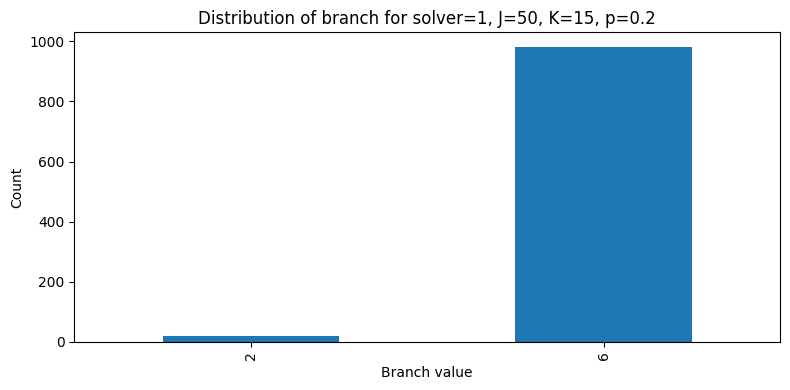

(312.0650109164984, 317.78820424342126, 0.9819819819819819)

In [24]:
analyze_results(solver = 1, J = 50, K = 15, p = 0.2)


Summary Statistics:
                    Metric      Value
Average runtime (all sims) 305.524579
Average runtime (branch=6) 305.524579
   Proportion identifiable   1.000000


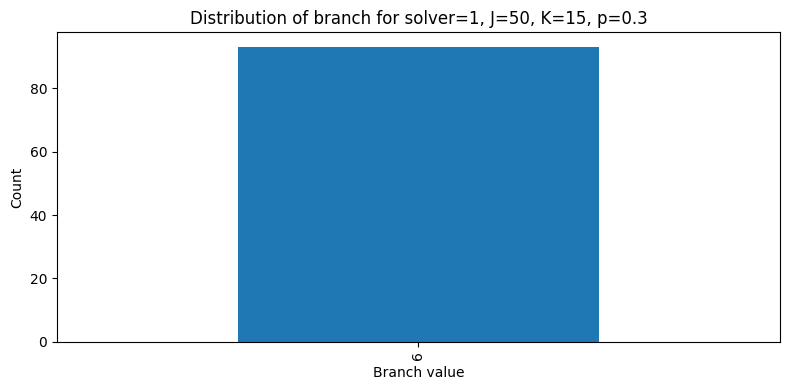

(305.5245790874926, 305.5245790874926, 1.0)

In [25]:
analyze_results(solver = 1, J = 50, K = 15, p = 0.3)


Summary Statistics:
                    Metric      Value
Average runtime (all sims) 467.394831
Average runtime (branch=6) 467.394831
   Proportion identifiable   1.000000


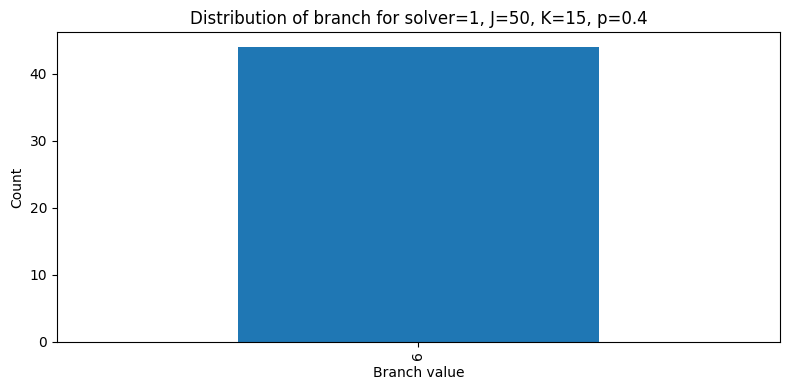

(467.3948314563273, 467.3948314563273, 1.0)

In [26]:
analyze_results(solver = 1, J = 50, K = 15, p = 0.4)